# Análise CEAP

---

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap

rc = {"font.family": "Ubuntu",  # fonte serifada
      "mathtext.fontset": "cm",  # texto matemático em LaTeX
      "font.size": 14,  # Usar tamanho 12 ou 14
      "axes.axisbelow": True,  # grid abaixo dos dados
      "text.usetex": False,
      "axes.grid": True, # grid por padrão
      }

%matplotlib inline

plt.rcParams.update(rc)


In [2]:
# UTILS
def wrap_labels(ax, width, break_long_words=False, axis='x'):
    labels = []
    if axis == 'y':
        for label in ax.get_yticklabels():
            text = label.get_text()
            labels.append(textwrap.fill(text, width=width,
                        break_long_words=break_long_words))
        ax.set_yticklabels(labels, rotation=0)
        return
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                    break_long_words=break_long_words))
        ax.set_xticklabels(labels, rotation=0)

# Dia 1 - Data Wrangling

Antes de começar a limpar os dados, vamos coletar com o `wget`

In [3]:
# !wget -P ./data/ https://www.senado.gov.br/transparencia/LAI/verba/despesa_ceaps_2021.csv

In [4]:
#TODO Achar uma maneira mais eficiente de detectar encoding

df = pd.read_csv('./data/despesa_ceaps_2021.csv', sep=';',
                skiprows=1, encoding='ISO-8859-9')

df.head(3)

,ANO,MES,SENADOR,TIPO_DESPESA,CNPJ_CPF,FORNECEDOR,DOCUMENTO,DATA,DETALHAMENTO,VALOR_REEMBOLSADO,COD_DOCUMENTO
0,2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",05.914.650/0001-66,ENERGISA,023.489.627,21/01/2021,Pagamento de energia elétrica para uso do escr...,"75,29",2158003
1,2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",062.135.728-64,FERNANDO WALDEIR PACINI e ANA LUCIA DA SILVA S...,01/2021,05/01/2021,Despesa com pagamento de aluguel de imóvel par...,1000,2157367
2,2021,1,ACIR GURGACZ,"Aluguel de imóveis para escritório político, c...",004.948.028-63,GILBERTO PISELO DO NASCIMENTO,001/21,06/01/2021,Despesa com aluguel de imóvel para uso do escr...,6000,2156383


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16827 entries, 0 to 16826
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ANO                16827 non-null  int64 
 1   MES                16827 non-null  int64 
 2   SENADOR            16827 non-null  object
 3   TIPO_DESPESA       16827 non-null  object
 4   CNPJ_CPF           16827 non-null  object
 5   FORNECEDOR         16827 non-null  object
 6   DOCUMENTO          16152 non-null  object
 7   DATA               16827 non-null  object
 8   DETALHAMENTO       9201 non-null   object
 9   VALOR_REEMBOLSADO  16827 non-null  object
 10  COD_DOCUMENTO      16827 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 1.4+ MB


## Mês e ano

Começando pelas colunas de ano e mês, verifica-se que nenhum registro é nulo, e seu tipo `int64` é adequado. Confere-se então se não há nenhuma anomalia nos dados de ano e mês:

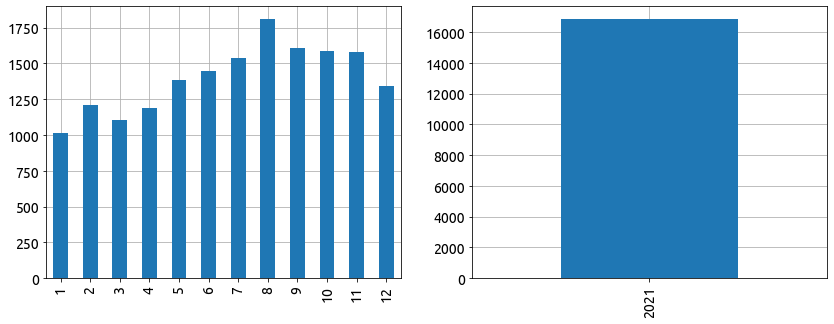

In [6]:
f, ax = plt.subplots(ncols=2, figsize=(14,5))

df['MES'].value_counts().sort_index().plot.bar(ax=ax[0])
df['ANO'].value_counts().sort_index().plot.bar(ax=ax[1])


plt.show()

Percebe-se que nenhum dos dados consta com anomalia de mês e ano. Na verdade o dado de mês e ano podem até ser descartados, pois sabe-se que o ano é 2021 somente, e o mês pode ser recuperado à partir do registro de datas. É possível então remover essas colunas.

In [7]:
df.drop(['ANO', 'MES'], inplace=True, axis=1)

## Senadores

Prosseguindo agora para o registro dos senadores, que não há nenhum registro nulo e seu tipo é `string` (ou `object`):

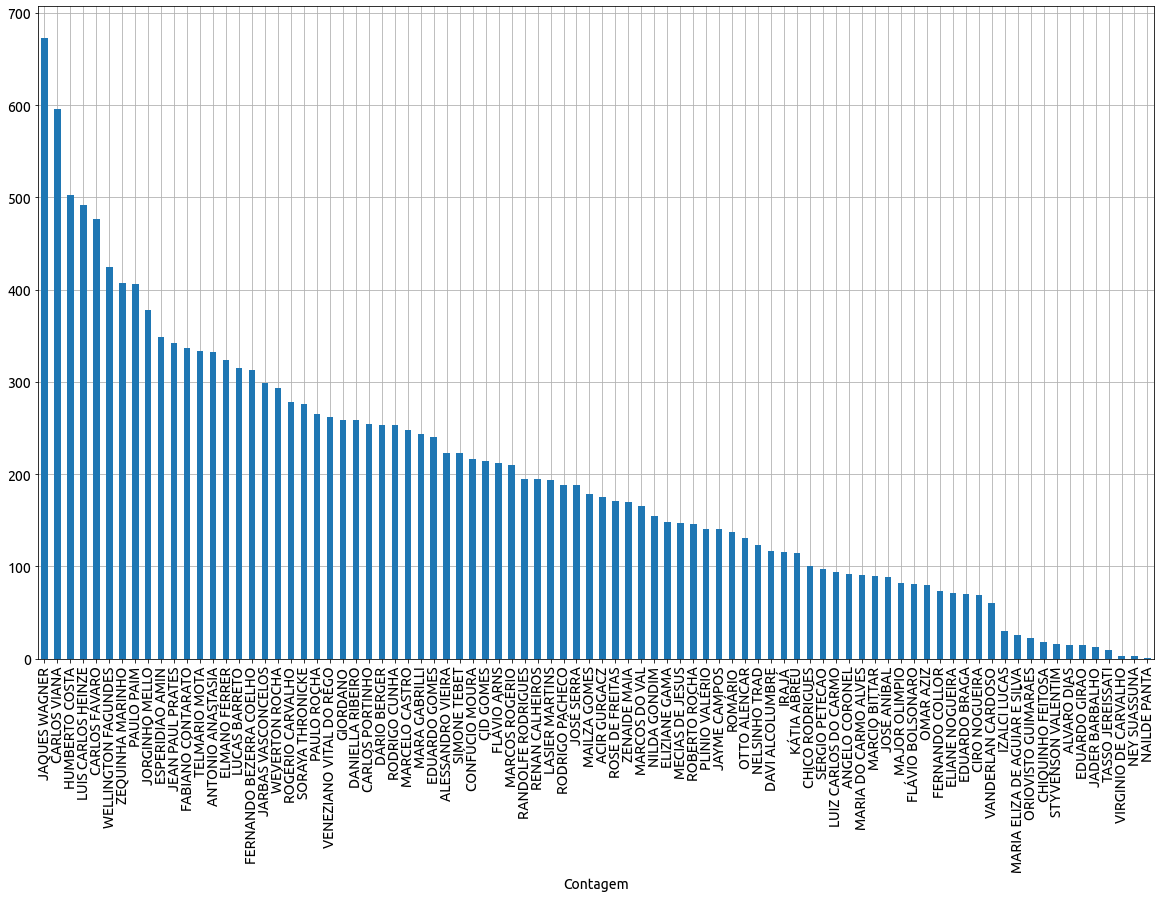

In [8]:
f, ax = plt.subplots(figsize=(20,12))

df['SENADOR'].value_counts().plot.bar(ax=ax)
ax.set(
  xlabel='Contagem')
    

plt.show()

Não há nenhum registro anormal no campo de senadores, como mostra a figura acima.

## Tipos de despesas

Verificando agora os tipos de despesa:

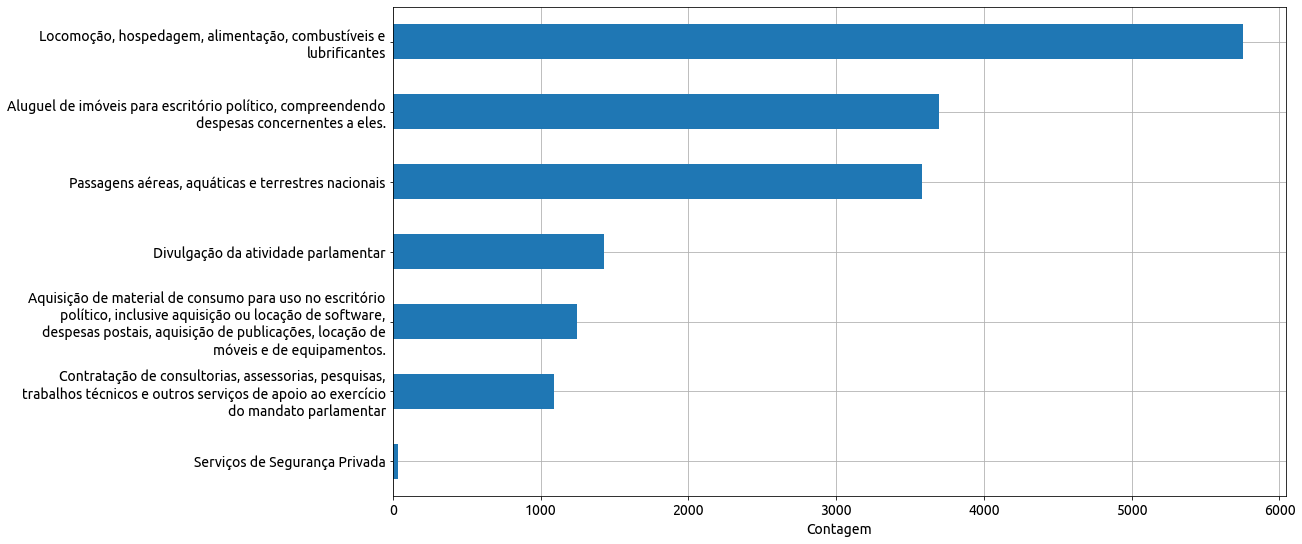

In [9]:
f, ax = plt.subplots(figsize=(16,9))

df['TIPO_DESPESA'].value_counts().sort_values().plot.barh(ax=ax)
ax.set(
  xlabel='Contagem')
    
wrap_labels(ax, 60, axis='y')

plt.show()

Nenhuma anormalidade -- apesar de lubrificante estar elencado como um tipo de despesa --, os dados parecem normais.

## CPF/CNPJ

Acerca da coluna `CPF_CNPJ`, inicialmente não há como saber se são referentes aos senadores ou aos fornecedores, pois ambos são candidatos à terem este valor cadastrado na transação. O candidato mais forte é o senador já que os dados são referentes às despesas do mesmo. Conferindo se há a mesma quantidade de senadores, CPF/CNPJ e fornecedores:

In [10]:
print('Quantidade de CPF/CNPJ distintos: ' + str(len(df['CNPJ_CPF'].value_counts().values)),
      'Quantidade de fornecedores distintos: ' + str(len(df['FORNECEDOR'].value_counts().values)),
      'Quantidade de senadores distintos: ' + str(len(df['SENADOR'].value_counts().values)), 
      sep='\n')

Quantidade de CPF/CNPJ distintos: 2800
Quantidade de fornecedores distintos: 2994
Quantidade de senadores distintos: 86


Aparentemente a quantidade de CPF/CNPJ cadastrados é mais próxima da quantidade de fornecedores, logo, deve ser relacionado com estes. 

Não sei se é necessário converter o CPF/CNPJ para tipo numérico, então por enquanto vai como `object`. Conforme a análise avançar eu volto aqui.

In [11]:
df['CNPJ_CPF']

0        05.914.650/0001-66
1            062.135.728-64
2            004.948.028-63
3        26.320.603/0001-64
4        13.659.201/0001-47
                ...        
16822    22.052.777/0001-32
16823    22.052.777/0001-32
16824    22.052.777/0001-32
16825    22.052.777/0001-32
16826    22.052.777/0001-32
Name: CNPJ_CPF, Length: 16827, dtype: object

## Documento

Tratando agora a coluna de documentos, que é a primeira que tem valores faltantes:

In [12]:
df['DOCUMENTO'].value_counts()[:50]

S/N                50
s/n                42
sn                 22
000000             14
10                 13
12987915           12
0351295303         12
S / N              11
2004/272           11
27                 11
47                 10
8                  10
9                  10
09/2021             9
05/2021             9
01                  9
30                  9
2063063040          9
000                 9
0356273429          9
0367832877          9
0303829681          8
28                  8
29                  8
24                  8
35                  8
2091837660          8
08/2021             8
14889889            8
11/2021             8
00001119670171      8
202100000000014     8
2                   8
508/003110927       7
12827220380         7
202100000000003     7
7                   7
14889960            7
12/2021             7
26                  7
202100000000017     7
13009991180         7
12109800460         7
00000075            7
1125999039          7
03/2021   

Podemos concentrar os documentos faltantes ou nulos ('S/N' e suas variações, '000000') numa única variável 'S/N', já que não há como recuperá-los.

In [13]:
df['DOCUMENTO'].fillna('S/N', inplace=True)
df['DOCUMENTO'].replace('s/n|S / N|sn|000000', 'S/N', regex=True, inplace=True)

## Data

Conferindo agora as datas, aparentemente todos os valores são não-nulos. Verifica-se então se todas as datas estão completas (têm 10 dígitos contando com os parêntesis - dd/mm/yyyy):

In [14]:
df['DATA'].apply(lambda x: len(x) != 10).sum()

0

In [15]:
df['DATA'].value_counts()

01/12/2021    130
01/07/2021    129
01/09/2021    117
01/06/2021    113
01/10/2021    107
             ... 
16/02/2022      1
25/12/2020      1
13/01/2020      1
24/02/2020      1
04/02/2020      1
Name: DATA, Length: 450, dtype: int64

Como aparentemente as datas estão limpas, só convertemos de 'object' para 'datetime64'

Após falhar na conversão de datas, verifica-se que há alguumas data com o ano '0202'. Como aparentemente é apenas esse padrão, substitui-se manualmente:

In [16]:
df.loc[:, 'DATA'].replace('0202', '2021',regex=True, inplace=True)


In [17]:
df['DATA'] = pd.to_datetime(df['DATA'], format='%d/%m/%Y')


## Detalhamento

No detalhamento não há como imputar dados faltantes de forma diferente de "não disponível". Uma opção pode ser copiar a coluna de `TIPO_DESPESA` para essa coluna, mas, por enquanto, vamos só substituir por "N/D"

In [18]:
df['DETALHAMENTO'].value_counts()

DESPESA COM COMBUSTÍVEL EM VEÍCULOS UTILIZADOS NA ATIVIDADE PARLAMENTAR.                                                                                 481
Despesa com combustível para veículo utilizado durante a atividade parlamentar.                                                                          163
Despesa com aquisição de combustível para veículo utilizado na atividade parlamentar                                                                     155
Despesa com divulgação da atividade parlamentar                                                                                                          129
Aquisição de combustível para veículos utilizados na atividade parlamentar.                                                                              126
                                                                                                                                                        ... 
Material de expediente para o escritório parlamentar no es

In [19]:
df['DETALHAMENTO'].fillna('N/D', inplace=True)

## Valor reembolsado

Nessa coluna não há valores faltantes, mas o tipo de dado é `object`. Para converter par aum tipo numérico, basta trocar as vírgulas por ponto e realizar um casting.

In [20]:
df['VALOR_REEMBOLSADO'] = df['VALOR_REEMBOLSADO'].replace(',','.', regex=True).astype('float64')

Ao final, nossos dados devem ser todos não nulos e com tipagem coerente:

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16827 entries, 0 to 16826
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   SENADOR            16827 non-null  object        
 1   TIPO_DESPESA       16827 non-null  object        
 2   CNPJ_CPF           16827 non-null  object        
 3   FORNECEDOR         16827 non-null  object        
 4   DOCUMENTO          16827 non-null  object        
 5   DATA               16827 non-null  datetime64[ns]
 6   DETALHAMENTO       16827 non-null  object        
 7   VALOR_REEMBOLSADO  16827 non-null  float64       
 8   COD_DOCUMENTO      16827 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 1.2+ MB
